In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng

from scipy.sparse import save_npz, load_npz

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

from sklearn.cluster import KMeans

from os.path import expanduser, join

from collections import Counter

import abs_tag_lib as at

## Obtain dataset

Let's first load the metadata archive into a panda dataframe (we can do this in one go since the size of the archive is not unbearable, although we are at the limit). To deal with it otherwise, we would have to stream the json file.

In [19]:
# path to metadata archive
home = expanduser("~")
path_archive = join(home,'Downloads/archive.zip')

# load the archive in pandas dataframe
df = pd.read_json(path_archive,lines=True)

We are here interested in the high energy physics category of the arXiv, especially the theoretical one. We select the items within this category, and the columns we are interested in.

In [21]:
# The category and year we are interested in
category = 'hep-th'
year = 2015

# The relevant columns for us
relevant_columns = ['id','title','abstract','update_date','authors_parsed']

# Select papers according to category
relevant_items = df['categories'].apply(lambda item : category in item)
df_hep = df[relevant_items][relevant_columns].copy()
df_hep.drop_duplicates(subset='id',inplace=True)

# Select papers according to year
df_hep['update_date'] = df_hep['update_date'].astype(dtype='datetime64[ns]')
relevant_years = df_hep['update_date'].dt.year == year
df_hep = df_hep[relevant_years]

df_hep.reset_index(drop=True,inplace=True)

# save cleaned dataframe 
df_hep.to_pickle('./dataset/dataset_hep.pkl')

## Cleaning title and abstracts



In [22]:
df_hep = pd.read_pickle('./dataset/dataset_hep.pkl')
df_hep.tail()

,id,title,abstract,update_date,authors_parsed
17121,solv-int/9701021,Is the classical Bukhvostov-Lipatov model inte...,"In this work we apply the Weiss, Tabor and C...",2015-06-26,"[[Ameduri, Marco, ], [Efthimiou, Costas J., ]]"
17122,solv-int/9804005,"On the relation between orthogonal, symplectic...",For the unitary ensembles of $N\times N$ Her...,2015-06-26,"[[Widom, Harold, , University of California, S..."
17123,solv-int/9807008,Separation of Variables in the Elliptic Gaudin...,For the elliptic Gaudin model (a degenerate ...,2015-11-13,"[[Sklyanin, Evgueni K., ], [Takebe, Takashi, ]]"
17124,solv-int/9907021,Supersymmetric KP hierarchy in N=1 superspace ...,A wide class of N=2 reductions of the supers...,2015-06-26,"[[Lechtenfeld, Olaf, ], [Sorin, Alexander, ]]"
17125,solv-int/9910010,Schlesinger transformations for elliptic isomo...,Schlesinger transformations are discrete mon...,2015-06-26,"[[Korotkin, D., ], [Manojlovic, N., ], [Samtle..."


We are now going to clean the abstracts and titles, that is,
- removing latex equations
- removing punctuation
- setting the words in lowercase
- remove stopwords
- lemmatize the words

In [23]:
# Our choice of lemmatizer and stopwords
wnl = WordNetLemmatizer()
stpw = stopwords.words('english')

# Cleaning the title and abstacts
df_hep['clean_title'] = df_hep['title'].apply(at.clean_text_lemmatize,args=(wnl,stpw))
df_hep['clean_abstract'] = df_hep['abstract'].apply(at.clean_text_lemmatize,args=(wnl,stpw))

Let's check what are the most common words,

In [24]:
words = np.hstack((df_hep['clean_title'],df_hep['clean_abstract']))
words = np.concatenate(words)

full_vocabulary = Counter(words)
full_vocabulary.most_common(10)

[('theory', 20578),
 ('field', 16263),
 ('model', 14170),
 ('non', 8183),
 ('quantum', 8005),
 ('gauge', 7785),
 ('2', 7633),
 ('n', 7539),
 ('space', 7133),
 ('two', 6926)]

And the total number of unique words,

In [25]:
len(full_vocabulary.keys())

20944

We can get rid of non-frequent words in the vocabulary, since they will probably not be useful, and in this way we should reduce the size of the vocabulary (the features, since we will use TF-IDF vectorization later on).

In [36]:
# words with a count higher than min_count are kept in the vocabulary
min_count = 5

vocabulary = [word for word in full_vocabulary.keys() if full_vocabulary[word] > min_count]

The total number of words in the vocabulary is then,

In [37]:
len(vocabulary)

7715

Let's now remove the words that are not in the vocabulary from the title and abstacts,

In [38]:
in_vocabulary_words = lambda item : [word for word in item if word in vocabulary]

df_hep['clean_title'] = df_hep['clean_title'].apply(in_vocabulary_words)
df_hep['clean_abstract'] = df_hep['clean_abstract'].apply(in_vocabulary_words)

We can check if the transformation performed above has empited any of the titles of abstracts, and what is the distributions of lenghts,

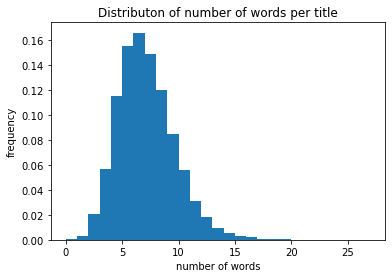

Range for # words in title = 0 - 27


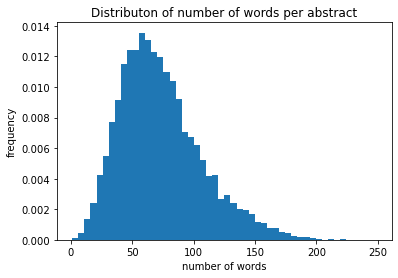

Range for # words in abstract = 1 - 249


In [39]:
title_lengths = df_hep['clean_title'].apply(len).to_numpy()
abstract_lengths = df_hep['clean_abstract'].apply(len).to_numpy()

plt.hist(title_lengths,bins=27,density=True)
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Distributon of number of words per title')
plt.show()

print('Range for # words in title = {} - {}'.format(min(title_lengths),
                                                    max(title_lengths)
                                                   )
     )

plt.hist(abstract_lengths,bins=50,density=True)
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Distributon of number of words per abstract')
plt.show()

print('Range for # words in abstract = {} - {}'.format(min(abstract_lengths),
                                                       max(abstract_lengths)
                                                      )
     )

We can get rid of those entries with a title with less that 3 words, and an abstract of less than 10 words, I think.

In [40]:
min_count_title = 3
min_count_abstract = 10

bool_keep = np.logical_and(title_lengths>=min_count_title, abstract_lengths>=min_count_abstract)
df_hep = df_hep[bool_keep].reset_index(drop=True)

And finally save the cleaned dataset,

In [41]:
df_hep.to_pickle('./dataset/dataset_hep_cleaned.pkl')

## Pre-processing title and abstracts

We can now pre-process the data. We are going to apply TF-IDF on the joint title and abstract.

In [25]:
df_hep = pd.read_pickle('./dataset/dataset_hep_cleaned.pkl')
df_hep.tail()

,id,title,abstract,update_date,authors_parsed,clean_title,clean_abstract
16668,solv-int/9701021,Is the classical Bukhvostov-Lipatov model inte...,"In this work we apply the Weiss, Tabor and C...",2015-06-26,"[[Ameduri, Marco, ], [Efthimiou, Costas J., ]]","[classical, lipatov, model, integrable, painle...","[work, apply, wei, integrability, criterion, p..."
16669,solv-int/9804005,"On the relation between orthogonal, symplectic...",For the unitary ensembles of $N\times N$ Her...,2015-06-26,"[[Widom, Harold, , University of California, S...","[relation, orthogonal, symplectic, unitary, ma...","[unitary, ensemble, hermitian, matrix, associa..."
16670,solv-int/9807008,Separation of Variables in the Elliptic Gaudin...,For the elliptic Gaudin model (a degenerate ...,2015-11-13,"[[Sklyanin, Evgueni K., ], [Takebe, Takashi, ]]","[separation, variable, elliptic, gaudin, model]","[elliptic, gaudin, model, degenerate, case, xy..."
16671,solv-int/9907021,Supersymmetric KP hierarchy in N=1 superspace ...,A wide class of N=2 reductions of the supers...,2015-06-26,"[[Lechtenfeld, Olaf, ], [Sorin, Alexander, ]]","[supersymmetric, kp, hierarchy, n, 1, superspa...","[wide, class, n, 2, reduction, supersymmetric,..."
16672,solv-int/9910010,Schlesinger transformations for elliptic isomo...,Schlesinger transformations are discrete mon...,2015-06-26,"[[Korotkin, D., ], [Manojlovic, N., ], [Samtle...","[schlesinger, transformation, elliptic, isomon...","[schlesinger, transformation, discrete, monodr..."


In [43]:
full_corpus = (df_hep['clean_title']+df_hep['clean_abstract']).to_numpy()

# This is needed since we did all the pre-processing outside sklearn
tokens_to_string = np.vectorize(lambda word_list: ' '.join(word_list))

full_corpus = tokens_to_string(full_corpus)

# Let's create the vectorized matrix (while splitting the corpus back into tokens)
vectorizer = TfidfVectorizer(analyzer=str.split)
X = vectorizer.fit_transform(full_corpus)

features = np.array(vectorizer.get_feature_names())

print('The dataset is composed of {} observations and {} features'.format(*X.shape))

The dataset is composed of 16673 observations and 7712 features


In [44]:
save_npz('./dataset/vectorized/X',X)
np.save('./dataset/vectorized/features',features)

## Visualizing the data distribution

Before we start clustering, we'd be interested in checking if the data can indeed be divided into clear clusters. Since checking this in the vectors space we have embedded the features is not possible, we use Multi-Dimensional Scaling (the distance between entries is computed in the high-dimensional vector space, and the items are then represented in 2D while preserving the distance).

Since the number of items we have is too big for computing the similarity matrix and storing it, we sample part of the dataset and use MDS on this subset.

In [2]:
X = load_npz('./dataset/vectorized/X.npz')
features = np.load('./dataset/vectorized/features.npy',allow_pickle=True)

Let's visualize a subset of X randomly sampled,

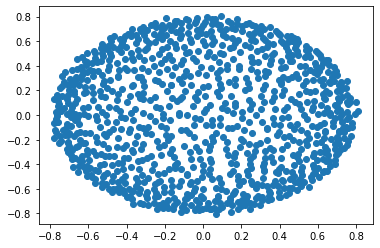

In [21]:
N,_ = X.shape
M = 1000

# Let's sample M items from the dataset, and perform MDS on them
rng = default_rng(seed=8362)
index = rng.choice(N,size=M, replace=False)
sub_X = X[index]

# Let instatiate the multi-dimensional scaling method (we plot the items in 2 dimensions)
mds = MDS(n_components=2,
          n_init=10,
          n_jobs=-1,
          dissimilarity='precomputed'
         )

# We compute the distance between items usign cosine similarity
dist = pairwise_distances(sub_X,metric='cosine',n_jobs=-1)

# We fit the data and represent the items in 2 dimension
sub_X_2D = mds.fit_transform(dist)

# Finally, we plot the items
plt.scatter(*sub_X_2D.T)
plt.show()

From the MDS, it is difficult to see any clusters, really. Other techniques we could use include PCA, but it require the matrix to be dense, and this would be difficult here.

## Clustering

## K-means

We start using K-means, which groups observations into K clusters, using their euclidian distance from the centre of the cluster. This algorithm minimize the within-point scatter,

$W(K) = \sum_{k=1}^K \sum_{i,j \in C_k} \| x_i - x_j \|_2$

In what follow, we use the above measure to estimate the optimal number of clusters for the dataset. An heuristic way to do this is to check the curve of whitin-point scatter as the number of clusters increase, and select the optimal number where an elbow can be seen.

Another technique to identify the optimal number of clusters is the gap statistics, but we do not implement it here.

In [25]:
# The max number of clusters and repeated fits to use
M = 20
K = 10

wps_mean = []
wps_std_err = []

for m in range(1,M+1):
    
    wps = []
    
    for _ in range(K):
        
        # Fir K-means with m clusters
        kmeans = KMeans(n_clusters=m)
        kmeans.fit(X)
        
        # Compute the within-point scatter
        wps.append(at.within_point_scatter(X,kmeans.labels_,kmeans.cluster_centers_))

    wps_mean.append(np.mean(wps))
    wps_std_err.append(np.std(wps)/np.sqrt(K))

Let's visualize the within point scatter,

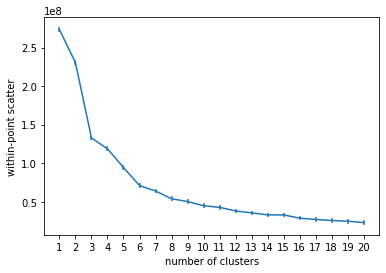

In [14]:
cluster_numbers = np.arange(1,M+1)

plt.errorbar(cluster_numbers,wps_mean,yerr=wps_std_err)
plt.xticks(cluster_numbers)
plt.xlabel('number of clusters')
plt.ylabel('within-point scatter')
plt.show()

Using the elbow rule described above, the optimal number of clusters might be 3, 6, or 8.

### Understanding the clusters

Let's train the model and check the centroids to get a better idea of what the different clusters represent.

In [19]:
m = 6

kmeans= KMeans(n_clusters=m,
               n_init=50,
              )
kmeans.fit(X)

KMeans(n_clusters=6, n_init=50)

We can get an idea of the clusters by looking at the feature importance of the cluster's centres. Since the centres are obtained as a mean of the item inside the cluster, in this way we get the mean feature importance of words over the papers included in the cluster. 

In [20]:
feature_importance_cluster(kmeans.cluster_centers_,kmeans.labels_,features)

Cluster 0 - # of items = 377
    - entropy : 0.248
    - entanglement : 0.217
    - holographic : 0.061
    - surface : 0.041
    - state : 0.035
    - theory : 0.034
    - quantum : 0.032
    - field : 0.030
    - gravity : 0.029
    - renyi : 0.028
Cluster 1 - # of items = 1357
    - black : 0.220
    - hole : 0.209
    - horizon : 0.059
    - solution : 0.049
    - entropy : 0.032
    - gravity : 0.030
    - charged : 0.029
    - ad : 0.027
    - scalar : 0.026
    - field : 0.026
Cluster 2 - # of items = 7714
    - quantum : 0.032
    - field : 0.030
    - model : 0.029
    - theory : 0.025
    - equation : 0.023
    - function : 0.022
    - space : 0.021
    - system : 0.019
    - gravity : 0.018
    - two : 0.017
Cluster 3 - # of items = 3235
    - theory : 0.078
    - string : 0.066
    - gauge : 0.064
    - field : 0.041
    - model : 0.028
    - symmetry : 0.027
    - non : 0.027
    - duality : 0.027
    - branes : 0.027
    - brane : 0.027
Cluster 4 - # of items = 2277
    -

Here we report the results from different choices of K (since K-means randomly initialize the clusters, repeating the above will give slightly different classes).

With 3 clusters, the division of papers is quite uneven,
- 1 big cluster with general quantum field theory papers (~ 10000)
- 1 medium cluster with gauge theories.
- 1 small cluster with black-hole physics/ads-cft correspondence.

With 6 clusters, the division of papers is a bit better, but many papers are still in a big cluster.
- 1 big cluster (~ 7500 papers): general quantum field theory.
- 4 medium clusters (1000-3000 papers): gauge theories, cosmology, supersymmetry, black-hole physics.
- 1 small cluster (~ 400 papers): ads-cft correspondence.

With 8 clusters, we get some specific clusters together with general ones.
- 2 big cluster (~ 5000 papers): general quantum field theory, gauge theory (+more?)
- medium (~1500) : supersymmetry, black-hole physics, cosmology
- small (< 1000): string theory, ads-cft correspondence, Yang-Mills theory (subfield of gauge theory)

### Example of clustered papers

We can check the papers in each clusters to see if they indeed belong to the subfield we predicted from the cluster centre. For example,

In [51]:
# choice of cluster
k = 0

# randomly sample the indices of papers in the cluster
indices_k = np.arange(N)[kmeans.labels_ == k]
index = np.random.choice(indices_k)

# a random example of the paper
print('TITLE : {}'.format(df_hep.iloc[index]['title']))
print('ABS : {}'.format(df_hep.iloc[index]['abstract']))

TITLE : Wormholes and entanglement in holography
ABS :   In this essay, we consider highly entangled states in theories with a gravity
dual, where the entangled degrees of freedom are causally disconnected from
each other. Using the basic rules of holography, we argue that there is a
non-traversable wormhole in the gravity dual whose geometry encodes the pattern
of the entanglement.



## Hierarchical clustering